In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from aia_sparse_deconvolve import *

In [10]:
# Image cutout size and center 
nx = int(128) #;int(96)
ny = int(128) #int(96)
bit_depth = 14.0
mode = 'mock' # or 'real'

#Read in Image
if mode == 'mock':
    hdulist = fits.open('./AIA20131108_043210_0304.fits')
    data = hdulist[0].data
    data = np.array(data,dtype=float)
    xcenter = 1550
    ycenter = 1680
    #print(data.shape)
    #data[int(xcenter-nx/2):int(xcenter+nx/2),int(ycenter-ny/2):int(ycenter+ny/2)]
    wavelnth = hdulist[0].header['WAVELNTH']

elif mode == 'real':
    # Read AIA saturated image
    #hdulist = fits.open('./AIA_304_saturated_uncomp.fits')
    #ycenter=1680
    #xcenter=2450
    
    hdulist = fits.open('./AIA_171_saturated_uncomp.fits')
    ycenter=1670
    xcenter=2400
    #hdulist = fits.open('/Users/cheung/AIA/X8.2Flare/AIA_131_saturated.fits')
    #xcenter = 3680
    #ycenter = 1815-30
    
    wavelnth = hdulist[1].header['WAVELNTH']
    data = hdulist[1].data.T
    data = np.array(data,dtype=float)


In [11]:
# C is the point spread function in stored sparse matrix form
pfile = "/Users/cheung/AIA/weber_psfs_rc/psf_sparse_{0:03d}_{1:03d}x{2:03d}.npz".format(wavelnth, nx, ny)
restore = True
if restore:
    rest = np.load(pfile)
    C = rest['C'].tolist()
    d_array = rest['d_array']
    i_array = rest['i_array']
    j_array = rest['j_array']
else:
    C, d_array, i_array, j_array = read_psf(wavelnth,(nx,ny),dir='/Users/cheung/AIA/weber_psfs_rc') 
    np.savez_compressed(pfile,C=C, d_array=d_array, i_array=i_array, j_array=j_array, nx=nx, ny=ny)

In [ ]:
# Cinv is the straight matrix inverse
# The reason we convert C to dense form first is because it seems to be faster for computing Cinv
# But for lasso it seems faster to have C in sparse form. 
if mode == 'mock':
    Cinv = np.linalg.inv(np.array(C.todense()))

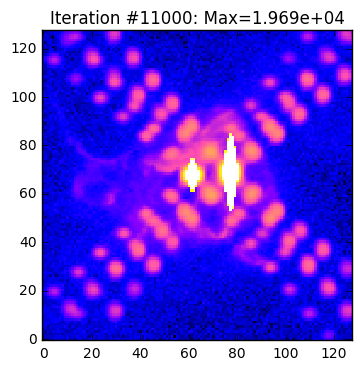

In [ ]:
if mode == 'mock': 
    #artificially decrease exptime by factor of 100
    obj = data[xcenter-nx/2:xcenter+nx/2,ycenter-ny/2:ycenter+ny/2]/30.0
    #Add a flare kernel
    yy = np.arange(10)-4.5
    yy = yy.reshape((10,1))
    np.matmul(yy, np.ones(shape=(1,10))).shape
    xx = yy.T
    obj[nx/2+8:nx/2+18,ny/2:ny/2+10] += np.exp((-xx**2.*0.4-yy**2*0.8)/3.)*(2.**17)
    obj[nx/2+10:nx/2+20,ny/2:ny/2+10] += np.exp((-xx**2*0.4-yy**2)/2.0)*(2.**16.5)
    #obj[38+5:48+5,48+1:58+1] += np.exp((-xx**2*0.1-yy**2*0.2)/2.0)*(2.**16.5)
    obj[nx/2-7:nx/2-7+10,ny/2-1:ny/2+10-1] += np.exp((-xx**2.*0.3-yy**2*0.2))*(2.**16.5)
    #Convolve object with PSF to make img
    img = (C.dot(obj.ravel().T)).reshape(nx,ny)
    #add poisson noise
    noise = np.random.poisson(5.,nx*ny).reshape(nx,ny)
    img = img + noise
    #Saturation
    img2=np.array(img,dtype=float)
    img2[:,:]=img[:,:]
    sat = bleed_wrapper(img2,bit_depth,displayFreq=1000)
else: 
    obj = data[xcenter-nx/2:xcenter+nx/2,ycenter-ny/2:ycenter+ny/2]
    img = np.array(obj)
    sat = img

In [ ]:
# Straight deconvolution on the saturated image
if mode == 'real':
    deconv = Cinv.dot(sat.ravel()).reshape(nx,ny)

In [ ]:
from sklearn import linear_model
from scipy.signal import convolve2d as scipy_convolve
model = linear_model.Lasso(alpha=1e-9, max_iter=2000,fit_intercept=False, positive=True)

desat = sparse_deconv(sat, d_array, i_array, j_array, bit_depth, gap=1.5, model=model)

if mode == 'mock':
    # Straight deconvolution on the saturated image
    deconv = Cinv.dot(sat.ravel()).reshape(nx,ny)
    images = (obj,img,sat,deconv,desat)
    labels = ('obj','img','sat','deconv','desat')
    types = ('plot','plot','plot','plot','scatter')
    clim = (2,16)
elif mode == 'real':
    smooth_kernel = np.array([[0.0625,0.25,0.0625],[0.25,1.0,0.25],[0.0625,0.25,0.0625]])
    smooth_kernel = smooth_kernel/smooth_kernel.sum()
    smooth = scipy_convolve(desat, smooth_kernel, mode='same')
    images = (img,  desat, smooth)
    labels = ('img','desat','desat,smoothed')
    types = ('plot','plot', 'plot')
    clim = (2,16)

for ycut in range(int(ny/2-14),int(ny/2+5),2):
    compare_imgs(images,labels,types,clim=clim, cmap='nipy_spectral', ycut=ycut)


desat.shape

In [240]:
hdulist[1].header['DATE-OBS']

'2011-02-15T01:49:50.69'